In [1]:
from __future__ import print_function

# from miscc.config import cfg, cfg_from_file
# from datasets import TextDataset
from trainer import JoImTeR as trainer
import pickle 
import os
import sys
import time
import math
import random
import pprint
import datetime
import dateutil.tz
import argparse
import numpy as np
import pandas as pd
from ast import literal_eval
pd.options.display.max_colwidth=0
from misc.config import Config
cfg = Config()
import json
from PIL import Image

from tqdm import tqdm
import torch
import torchvision.transforms as transforms

In [2]:
'''
Helper functions in MIT code for loading csv file with eval()
Below are just helper functions
'''
# to streamline the writing of the dataframe
def write_dataframe(df, filepath):
    df.to_csv(filepath, sep='\t', encoding='utf-8', index=False)

# to streamline the reading of the dataframe
def read_dataframe(filepath):
    df = pd.read_csv(filepath, sep='\t')
    def literal_eval_col(row, col_name):
        col = row[col_name]
        col = literal_eval(col)
        return col
    df['report'] = df.apply(literal_eval_col, args=('report',), axis=1)
    if 'origin_section' in df.columns:
        df['origin_section'] = df.apply(literal_eval_col, args=('origin_section',), axis=1)
    if 'normalized_report' in df.columns:
        df['normalized_report'] = df.apply(literal_eval_col, args=('normalized_report',), axis=1)
    #df['edema_severity'] = df.apply(literal_eval_col, args=('edema_severity',), axis=1)
    # metadata is a dictionary which is written into the csv format as a string
    # but in order to be treated as a dictionary it needs to be evaluated
    return df

# The goal here is to make sure that the df that is written into memory is the same one that is read
def check_equality_of_written_and_read_df(df, df_copy):
    bool_equality = df.equals(df_copy)
    # to double check, we want to check with every column
    bool_every_column = True
    for idx in range(len(df)):
        row1 = df.iloc[idx]
        row2 = df_copy.iloc[idx]
        # for any column names (grab the column names), then compare for all of them and print the 
        # column name where they differ
        if not np.array_equal(row1.index, row2.index):
            print("The two dataframes must have identical columns with their order!")
            return
        columns = row1.index
        for column_name in columns:
            if row1[column_name] != row2[column_name]:
                print("The dataframes differ in column: ", column_name)
                bool_every_column = False
                return bool_equality, bool_every_column
    return bool_equality, bool_every_column

# remove any additional whitespace within a line
def remove_whitespace(line):
    return str(" ".join(line.split()).strip())

# get a dictionary, return a string
# used to convert normalized report to 1 long sentence
def extract_report_from_normalized(normalized_report):
    return " ".join(normalized_report['sentences'])

# Dataset

In [3]:
path=os.getcwd() #Get the path
path

'/media/My1TBSSD1/IPMI2021/code'

In [20]:
frontal_ds = pd.read_csv('/media/MyDataStor2/MIMIC-CXR/frontal_info_mit.csv')
lm_report_ds = read_dataframe('/media/MyDataStor2/MIMIC-CXR/lm_reports/original_reports_mit_normalized.csv')

In [80]:
## broken images was found
## files/p19/p19017919/s50797181/8e5f8df3-4248d575-fd16f8c1-1c69065a-1ac199e9.dcm
## files/p18/p18441078/s58044074/15e60dc7-6493889f-d2cb9dba-2c860709-f171bc98.dcm
## files/p11/p11673861/s53517205/0491306a-d44bb1cd-36678cdf-ef64aa11-ee9897a2.dcm
## files/p15/p15398519/s52897917/6f9899f3-652a0fe6-cb32f8b1-3afb0c85-5a3929f0.dcm
## files/p13/p13118941/s54144739/67b68818-61703959-6321083a-ecf0ff32-addd5bc8.jpg
## files/p13/p13660399/s52532898/2f2d7a89-161059ab-bf24aaa4-c15f7abb-ea408fee.jpg
## files/p14/p14882082/s59150331/5009240f-7dc4006c-4a69d332-00051c01-9179f001.jpg
## files/p17/p17198774/s54162995/2d7e35ed-6f80d557-740804a5-c1cdc6f0-5729e6a6.jpg
## files/p17/p17199342/s59731194/b3e8c46c-99efe614-59b11837-a870ab41-8e30ceea.jpg
## files/p18/p18446282/s54914372/32b63c6b-837955f2-62cd29e6-834d5132-6f9c67d8.jpg
## files/p10/p10429567/s50092250/9b638b93-04eb16df-27abce62-5053672d-3a0b750b.jpg
## files/p18/p18046197/s54101455/03282542-659da086-ed15e343-f5666add-32d57195.jpg
# replaced broken images above
## bad image files/p11/p11285576/s54979966/03b2e67c-70631ff8-685825fb-6c989456-621ca64d.dcm
## bad image files/p11/p11378535/s50374044/db9511e3-ee0359ab-489c3556-4a9b2277-c0bf0369.dcm
## bad image files/p14/p14887088/s54257662/1bc85033-355accce-e8d0ed50-78188cd3-dac92e86.dcm
frontal_ds[frontal_ds['img'].isin(['files/p11/p11378535/s50374044/db9511e3-ee0359ab-489c3556-4a9b2277-c0bf0369.dcm',
                                  'files/p11/p11285576/s54979966/03b2e67c-70631ff8-685825fb-6c989456-621ca64d.dcm',
                                  'files/p14/p14887088/s54257662/1bc85033-355accce-e8d0ed50-78188cd3-dac92e86.dcm'])]

,uid,subject_id,study_id,dicom_id,img,txt,ViewPosition,Rows,Columns,split,official_split
31214,47388,11285576,54979966,03b2e67c-70631ff8-685825fb-6c989456-621ca64d,files/p11/p11285576/s54979966/03b2e67c-70631ff8-685825fb-6c989456-621ca64d.dcm,files/p11/p11285576/s54979966.txt,AP,697,3050,train,train
33517,50857,11378535,50374044,db9511e3-ee0359ab-489c3556-4a9b2277-c0bf0369,files/p11/p11378535/s50374044/db9511e3-ee0359ab-489c3556-4a9b2277-c0bf0369.dcm,files/p11/p11378535/s50374044.txt,AP,3050,805,train,train
120390,183446,14887088,54257662,1bc85033-355accce-e8d0ed50-78188cd3-dac92e86,files/p14/p14887088/s54257662/1bc85033-355accce-e8d0ed50-78188cd3-dac92e86.dcm,files/p14/p14887088/s54257662.txt,AP,2539,776,train,train


In [81]:
frontal_ds[frontal_ds['study_id']==54257662]
## also need to remove this study case with single bad image from text report. 

,uid,subject_id,study_id,dicom_id,img,txt,ViewPosition,Rows,Columns,split,official_split
120390,183446,14887088,54257662,1bc85033-355accce-e8d0ed50-78188cd3-dac92e86,files/p14/p14887088/s54257662/1bc85033-355accce-e8d0ed50-78188cd3-dac92e86.dcm,files/p14/p14887088/s54257662.txt,AP,2539,776,train,train


In [82]:
# each time read csv
# remove bad image rows from frontal_ds (and the corresponding reports from lm_report_ds (no need))
frontal_ds.drop(frontal_ds[frontal_ds['img'].isin(['files/p11/p11378535/s50374044/db9511e3-ee0359ab-489c3556-4a9b2277-c0bf0369.dcm',
                                  'files/p11/p11285576/s54979966/03b2e67c-70631ff8-685825fb-6c989456-621ca64d.dcm',
                                  'files/p14/p14887088/s54257662/1bc85033-355accce-e8d0ed50-78188cd3-dac92e86.dcm'])].index, inplace=True)

In [90]:
lm_report_ds.drop(lm_report_ds[lm_report_ds['filename']=='s54257662.txt'].index, inplace=True)

In [25]:
## check images here
## https://physionet.org/files/mimic-cxr-jpg/2.0.0/files/p18/p18446282/s54914372/32b63c6b-837955f2-62cd29e6-834d5132-6f9c67d8.jpg
# imgroot = '/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/'
# # Image.open(imgroot+frontal_ds['img'][1].replace('dcm', 'jpg'))
# img = Image.open(imgroot + 'files/p18/p18446282/s54914372/32b63c6b-837955f2-62cd29e6-834d5132-6f9c67d8.jpg')
# img

In [21]:
## ? maybe need to remove bad image files/p18/p18446282/s54914372/32b63c6b-837955f2-62cd29e6-834d5132-6f9c67d8.jpg
frontal_ds[frontal_ds['study_id']==54914372]

,uid,subject_id,study_id,dicom_id,img,txt,ViewPosition,Rows,Columns,split,official_split
209003,318521,18446282,54914372,16690210-2cc1bb02-e359ca9e-ad0d76e4-aec413a7,files/p18/p18446282/s54914372/16690210-2cc1bb02-e359ca9e-ad0d76e4-aec413a7.dcm,files/p18/p18446282/s54914372.txt,AP,3050,2539,train,train
209004,318522,18446282,54914372,32b63c6b-837955f2-62cd29e6-834d5132-6f9c67d8,files/p18/p18446282/s54914372/32b63c6b-837955f2-62cd29e6-834d5132-6f9c67d8.dcm,files/p18/p18446282/s54914372.txt,AP,3050,2539,train,train
209005,318523,18446282,54914372,590b6177-50716e0e-7f5300a9-886a2e9c-1af3ed01,files/p18/p18446282/s54914372/590b6177-50716e0e-7f5300a9-886a2e9c-1af3ed01.dcm,files/p18/p18446282/s54914372.txt,AP,3050,2539,train,train
209006,318524,18446282,54914372,6ca7ab4a-c989f7f0-9f03020e-0693a4fc-354d6f47,files/p18/p18446282/s54914372/6ca7ab4a-c989f7f0-9f03020e-0693a4fc-354d6f47.dcm,files/p18/p18446282/s54914372.txt,AP,3050,2539,train,train
209007,318525,18446282,54914372,c5b09acc-a6d4dad0-5f8037a2-e7939c67-5d36a016,files/p18/p18446282/s54914372/c5b09acc-a6d4dad0-5f8037a2-e7939c67-5d36a016.dcm,files/p18/p18446282/s54914372.txt,AP,3050,2539,train,train
209008,318526,18446282,54914372,d117ac9e-01c5a816-7b30760e-0b239ec4-935b177a,files/p18/p18446282/s54914372/d117ac9e-01c5a816-7b30760e-0b239ec4-935b177a.dcm,files/p18/p18446282/s54914372.txt,AP,3050,2539,train,train
209009,318527,18446282,54914372,d7a9d501-d24d5115-5e98a244-a807df3f-f44431be,files/p18/p18446282/s54914372/d7a9d501-d24d5115-5e98a244-a807df3f-f44431be.dcm,files/p18/p18446282/s54914372.txt,AP,3050,2539,train,train
209010,318528,18446282,54914372,e71710dc-8ba3d9cf-41a9eae8-12af97f6-1e92d263,files/p18/p18446282/s54914372/e71710dc-8ba3d9cf-41a9eae8-12af97f6-1e92d263.dcm,files/p18/p18446282/s54914372.txt,AP,3050,2539,train,train


In [85]:
frontal_ds

,uid,subject_id,study_id,dicom_id,img,txt,ViewPosition,Rows,Columns,split,official_split
0,0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.dcm,files/p10/p10000032/s50414267.txt,PA,3056,2544,train,train
1,2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab.dcm,files/p10/p10000032/s53189527.txt,PA,3056,2544,train,train
2,4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714.dcm,files/p10/p10000032/s53911762.txt,AP,2705,2539,train,train
3,5,10000032,53911762,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,files/p10/p10000032/s53911762/fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818.dcm,files/p10/p10000032/s53911762.txt,AP,2906,2258,train,train
4,6,10000032,56699142,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,files/p10/p10000032/s56699142/ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c.dcm,files/p10/p10000032/s56699142.txt,AP,3056,2544,train,train
...,...,...,...,...,...,...,...,...,...,...,...
250823,376658,19991135,57757467,727e2aa5-ddfdd2ff-b5723867-520a758e-c81ca8e2,files/p19/p19991135/s57757467/727e2aa5-ddfdd2ff-b5723867-520a758e-c81ca8e2.dcm,files/p19/p19991135/s57757467.txt,AP,3056,2544,hold,test
250824,376659,19991135,58283482,313f1d75-23648c34-dd36ecad-5d0f94e8-93a40356,files/p19/p19991135/s58283482/313f1d75-23648c34-dd36ecad-5d0f94e8-93a40356.dcm,files/p19/p19991135/s58283482.txt,AP,2544,3056,hold,test
250825,376660,19991135,58283482,4d0251eb-cc875c55-fde85f43-3a9d7888-c62772b8,files/p19/p19991135/s58283482/4d0251eb-cc875c55-fde85f43-3a9d7888-c62772b8.dcm,files/p19/p19991135/s58283482.txt,AP,2544,3056,hold,test
250826,376661,19991135,58283482,f6a7a470-9e057a45-d244e0e5-3efe1422-bb946478,files/p19/p19991135/s58283482/f6a7a470-9e057a45-d244e0e5-3efe1422-bb946478.dcm,files/p19/p19991135/s58283482.txt,AP,2544,3056,hold,test


In [91]:
lm_report_ds

,filename,report,original_report,origin_section,normalized_report
0,s50414267.txt,"{'final_report': {'examination': 'CHEST (PA AND LAT)', 'indication': 'DEID F with new onset ascites // eval for infection', 'technique': 'Chest PA and lateral', 'comparison': 'None.', 'findings': 'There is no focal consolidation, pleural effusion or pneumothorax. Bilateral nodular opacities that most likely represent nipple shadows. The cardiomediastinal silhouette is normal. Clips project over the left lung, potentially within the breast. The imaged upper abdomen is unremarkable. Chronic deformity of the posterior left sixth and seventh ribs are noted.', 'impression': 'No acute cardiopulmonary process.'}}","There is no focal consolidation, pleural effusion or pneumothorax. Bilateral nodular opacities that most likely represent nipple shadows. The cardiomediastinal silhouette is normal. Clips project over the left lung, potentially within the breast. The imaged upper abdomen is unremarkable. Chronic deformity of the posterior left sixth and seventh ribs are noted. No acute cardiopulmonary process.","[finding, impression]","{'sentences': ['There is no focal consolidation , pleural effusion or pneumothorax .', 'Bilateral nodular opacities that most likely represent nipple shadows .', 'The cardiomediastinal silhouette is normal .', 'Clips project over the left lung , potentially within the breast .', 'The imaged upper abdomen is unremarkable .', 'Chronic deformity of the posterior left NUMBER and NUMBER ribs are noted .', 'No acute cardiopulmonary process .']}"
1,s53189527.txt,"{'final_report': {'examination': 'CHEST (PA AND LAT)', 'indication': 'History: DEID F with shortness of breath', 'technique': 'Chest PA and lateral', 'comparison': 'DEID', 'findings': 'The cardiac, mediastinal and hilar contours are normal. Pulmonary vasculature is normal. Lungs are clear. No pleural effusion or pneumothorax is present. Multiple clips are again seen projecting over the left breast. Remote left-sided rib fractures are also re- demonstrated.', 'impression': 'No acute cardiopulmonary abnormality.'}}","The cardiac, mediastinal and hilar contours are normal. Pulmonary vasculature is normal. Lungs are clear. No pleural effusion or pneumothorax is present. Multiple clips are again seen projecting over the left breast. Remote left-sided rib fractures are also re- demonstrated. No acute cardiopulmonary abnormality.","[finding, impression]","{'sentences': ['The cardiac , mediastinal and hilar contours are normal .', 'Pulmonary vasculature is normal .', 'Lungs are clear .', 'No pleural effusion or pneumothorax is present .', 'Multiple clips are again seen projecting over the left breast .', 'Remote left-sided rib fractures are also re- demonstrated .', 'No acute cardiopulmonary abnormality .']}"
2,s53911762.txt,"{'final_report': {'examination': 'CHEST (PORTABLE AP)', 'indication': 'DEID F with cough // acute process?', 'comparison': 'Chest radiograph DEID', 'findings': 'Single frontal view of the chest provided. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Again seen are multiple clips projecting over the left breast and remote left-sided rib fractures. No free air below the right hemidiaphragm is seen.', 'impression': 'No acute intrathoracic process.'}}","Single frontal view of the chest provided. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Again seen are multiple clips projecting over the left breast and remote left-sided rib fractures. No free air below the right hemidiaphragm is seen. No acute intrathoracic process.","[finding, impression]","{'sentences': ['Single frontal view of the chest provided .', 'There is no focal consolidation , effusion , or pneumothorax .', 'The cardiomediastinal silhouette is normal .', 'Again seen are multiple clips projecting over the left breast and remote left-sided rib fractures .', 'No free air below the right hemi

In [93]:
## remove empty report rows
lm_report_ds[lm_report_ds['original_report'].isin([np.nan])]

,filename,report,original_report,origin_section,normalized_report
98751,s54168089.txt,{'final_report': ''},NaN,[],{'sentences': []}


In [94]:
## use df_report for following process
df_report = lm_report_ds.copy()
df_report.drop(df_report[df_report['filename'] == 's54168089.txt'].index, inplace = True) 
df_report

,filename,report,original_report,origin_section,normalized_report
0,s50414267.txt,"{'final_report': {'examination': 'CHEST (PA AND LAT)', 'indication': 'DEID F with new onset ascites // eval for infection', 'technique': 'Chest PA and lateral', 'comparison': 'None.', 'findings': 'There is no focal consolidation, pleural effusion or pneumothorax. Bilateral nodular opacities that most likely represent nipple shadows. The cardiomediastinal silhouette is normal. Clips project over the left lung, potentially within the breast. The imaged upper abdomen is unremarkable. Chronic deformity of the posterior left sixth and seventh ribs are noted.', 'impression': 'No acute cardiopulmonary process.'}}","There is no focal consolidation, pleural effusion or pneumothorax. Bilateral nodular opacities that most likely represent nipple shadows. The cardiomediastinal silhouette is normal. Clips project over the left lung, potentially within the breast. The imaged upper abdomen is unremarkable. Chronic deformity of the posterior left sixth and seventh ribs are noted. No acute cardiopulmonary process.","[finding, impression]","{'sentences': ['There is no focal consolidation , pleural effusion or pneumothorax .', 'Bilateral nodular opacities that most likely represent nipple shadows .', 'The cardiomediastinal silhouette is normal .', 'Clips project over the left lung , potentially within the breast .', 'The imaged upper abdomen is unremarkable .', 'Chronic deformity of the posterior left NUMBER and NUMBER ribs are noted .', 'No acute cardiopulmonary process .']}"
1,s53189527.txt,"{'final_report': {'examination': 'CHEST (PA AND LAT)', 'indication': 'History: DEID F with shortness of breath', 'technique': 'Chest PA and lateral', 'comparison': 'DEID', 'findings': 'The cardiac, mediastinal and hilar contours are normal. Pulmonary vasculature is normal. Lungs are clear. No pleural effusion or pneumothorax is present. Multiple clips are again seen projecting over the left breast. Remote left-sided rib fractures are also re- demonstrated.', 'impression': 'No acute cardiopulmonary abnormality.'}}","The cardiac, mediastinal and hilar contours are normal. Pulmonary vasculature is normal. Lungs are clear. No pleural effusion or pneumothorax is present. Multiple clips are again seen projecting over the left breast. Remote left-sided rib fractures are also re- demonstrated. No acute cardiopulmonary abnormality.","[finding, impression]","{'sentences': ['The cardiac , mediastinal and hilar contours are normal .', 'Pulmonary vasculature is normal .', 'Lungs are clear .', 'No pleural effusion or pneumothorax is present .', 'Multiple clips are again seen projecting over the left breast .', 'Remote left-sided rib fractures are also re- demonstrated .', 'No acute cardiopulmonary abnormality .']}"
2,s53911762.txt,"{'final_report': {'examination': 'CHEST (PORTABLE AP)', 'indication': 'DEID F with cough // acute process?', 'comparison': 'Chest radiograph DEID', 'findings': 'Single frontal view of the chest provided. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Again seen are multiple clips projecting over the left breast and remote left-sided rib fractures. No free air below the right hemidiaphragm is seen.', 'impression': 'No acute intrathoracic process.'}}","Single frontal view of the chest provided. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Again seen are multiple clips projecting over the left breast and remote left-sided rib fractures. No free air below the right hemidiaphragm is seen. No acute intrathoracic process.","[finding, impression]","{'sentences': ['Single frontal view of the chest provided .', 'There is no focal consolidation , effusion , or pneumothorax .', 'The cardiomediastinal silhouette is normal .', 'Again seen are multiple clips projecting over the left breast and remote left-sided rib fractures .', 'No free air below the right hemi

In [103]:
## also remove the corresponding images with this empty report from frontal_ds
frontal_ds.drop(frontal_ds[frontal_ds['study_id']==54168089].index, inplace=True)

In [105]:
## sanity check if the text report name (study id) in frontal_ds is the same set as lm_report_ds
def extract_txt(row, col_name):
    col = row[col_name]
    col = os.path.basename(col)
    return col
study1 = frontal_ds.apply(extract_txt, args=('txt',), axis=1).unique()
study2 = df_report['filename'].unique()
print(len(study1), len(study2))
np.array_equal(study1, study2)

225293 225293


True

In [161]:
## check. the split and official split
print('Train split %d, official split %d.' % 
      (frontal_ds[frontal_ds['split']=='train'].shape[0], frontal_ds[frontal_ds['official_split']=='train'].shape[0])) 
print('Validate split %d, official split %d.' % 
      (frontal_ds[frontal_ds['split']=='validate'].shape[0], frontal_ds[frontal_ds['official_split']=='validate'].shape[0])) 
print('Test split %d, official split %d.' % 
      (frontal_ds[frontal_ds['split']=='test'].shape[0], frontal_ds[frontal_ds['official_split']=='test'].shape[0])) 
print('Hold split %d, official split %d.' % 
      (frontal_ds[frontal_ds['split']=='hold'].shape[0], frontal_ds[frontal_ds['official_split']=='hold'].shape[0])) 

Train split 241805, official split 245660.
Validate split 2255, official split 1761.
Test split 3361, official split 3403.
Hold split 3403, official split 0.


In [162]:
## check. the split and official split on report level
print('Train split %d, official split %d.' % 
      (frontal_ds[frontal_ds['split']=='train']['study_id'].unique().shape[0], 
       frontal_ds[frontal_ds['official_split']=='train']['study_id'].unique().shape[0])) 
print('Validate split %d, official split %d.' % 
      (frontal_ds[frontal_ds['split']=='validate']['study_id'].unique().shape[0], 
       frontal_ds[frontal_ds['official_split']=='validate']['study_id'].unique().shape[0])) 
print('Test split %d, official split %d.' % 
      (frontal_ds[frontal_ds['split']=='test']['study_id'].unique().shape[0], 
       frontal_ds[frontal_ds['official_split']=='test']['study_id'].unique().shape[0])) 

Train split 217252, official split 220696.
Validate split 2000, official split 1556.
Test split 3000, official split 3041.


In [78]:
# frontal_ds[frontal_ds['study_id']==54168089] # empty report study id

,uid,subject_id,study_id,dicom_id,img,txt,ViewPosition,Rows,Columns,split,official_split
109903,167305,14463099,54168089,c8b18fab-d970277a-7e1f18df-95c19894-7bb3abce,files/p14/p14463099/s54168089/c8b18fab-d970277a-7e1f18df-95c19894-7bb3abce.dcm,files/p14/p14463099/s54168089.txt,PA,3056,2544,train,train


In [95]:
## check if empty report rows removed
df_report[df_report['original_report'].isin([np.nan])]
df_report[df_report['filename'] == 's54168089.txt']

,filename,report,original_report,origin_section,normalized_report


In [14]:
## deprecated due to a better version in MIT code
## refer to /media/MyDataStor2/zhanghex/torch-master/joint_chestxray/joint_img_txt/data_preprocessing/notebooks
## notebook: 'Data_Conversion_Language_Modeling.ipynb', 
## also more statistic info in 'Data_Conversion_joint_model_semisupervised.ipynb'

# text_reports = {}
# for i in tqdm(range(lm_report_ds.shape[0])):
#     s = []
#     try:
# #         t=json.loads(lm_report_ds.iloc[i]['report'].replace("'",'"'))
#         t = eval(lm_report_ds.iloc[i]['report'])
#         if t['final_report']!='':
#             if 'findings' in t['final_report'].keys():
#                 f = t['final_report']['findings']
#                 s.append(f if not isinstance(f,list) else ' '.join(f))
#             if 'impression' in t['final_report'].keys():
#                 imp = t['final_report']['impression']
#                 s.append(imp if not isinstance(imp,list) else ' '.join(imp))
#             if 'conclusion' in t['final_report'].keys():
#                 s.append(t['final_report']['conclusion'])
#             if 'recommendation' in t['final_report'].keys():
#                 s.append(t['final_report']['recommendation'])
#             if len(s)==0:
#                 for key in t['final_report'].keys():
#                     v = t['final_report'][key]
#                     s.append(v if not isinstance(v,list) else ' '.join(v))
                
#             if len(s)!=0:
#                 s_str = ' '.join(s)
#                 text_reports[lm_report_ds.iloc[i]['filename']] = s_str
#             else:
#                 print(lm_report_ds.iloc[i]['filename'])
#                 continue
#     except Exception as ex:
#         print('**** Error ****')
#         print(ex)
#         print(lm_report_ds.iloc[i]['filename'])
#         print(lm_report_ds.iloc[i]['report'])
#         print(t)
#         break

In [96]:
## generate text_reports dict, ['filename': normalized_report_single_sentence]
text_reports = {}
for i in tqdm(range(df_report.shape[0])):
    text_reports[df_report.iloc[i]['filename']] = extract_report_from_normalized(df_report.iloc[i]['normalized_report'])
print(len(text_reports))

100%|██████████| 225293/225293 [00:32<00:00, 6932.92it/s]

225293


In [97]:
text_reports['s56406919.txt'] # check if all impresssions are concatenated in one string

'-year-old male with aortic stenosis , congestive cardiac failure , and fall , evaluate for trauma . . The lungs are low in volume with crowding of bronchovascular markings , but no focal consolidation , or pneumothorax is noted . There is mild cardiomegaly . No definite rib fractures are identified . If there is continued clinical concern for rib fractures , then a dedicated rib series can be obtained . Small left pleural effusion can not be excluded .'

In [98]:
df_report[df_report['filename']=='s56406919.txt']

,filename,report,original_report,origin_section,normalized_report
185543,s56406919.txt,"{'final_report': {'indication': 'DEID -year-old male with aortic stenosis, congestive cardiac failure, and fall, evaluate for trauma.', 'comparison': 'DEID .', 'pa_and_lateral_chest_radiograph': 'The lungs are low in volume with crowding of bronchovascular markings, but no focal consolidation, or pneumothorax is noted. There is mild cardiomegaly. No definite rib fractures are identified. If there is continued clinical concern for rib fractures, then a dedicated rib series can be obtained. Small left pleural effusion cannot be excluded.'}}","DEID -year-old male with aortic stenosis, congestive cardiac failure, and fall, evaluate for trauma. DEID . The lungs are low in volume with crowding of bronchovascular markings, but no focal consolidation, or pneumothorax is noted. There is mild cardiomegaly. No definite rib fractures are identified. If there is continued clinical concern for rib fractures, then a dedicated rib series can be obtained. Small left pleural effusion cannot be excluded.",[final_report],"{'sentences': ['-year-old male with aortic stenosis , congestive cardiac failure , and fall , evaluate for trauma .', '.', 'The lungs are low in volume with crowding of bronchovascular markings , but no focal consolidation , or pneumothorax is noted .', 'There is mild cardiomegaly .', 'No definite rib fractures are identified .', 'If there is continued clinical concern for rib fractures , then a dedicated rib series can be obtained .', 'Small left pleural effusion can not be excluded .']}"


# Dataloader 

In [19]:
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
import torchvision as tv

import os,sys
import pandas as pd
import numpy as np
import pickle
from PIL import Image
import spacy
import scispacy
from tqdm import tqdm 
from nltk.tokenize import RegexpTokenizer
from transformers import BertTokenizer


In [100]:
## write the text_reports to pickle file temporately
# with open('/media/MyDataStor2/MIMIC-CXR/lm_reports/text_reports_mit_normalized.pkl','wb') as f:
#     pickle.dump(text_reports, f)
# text_reports = pickle.load(f)

In [21]:
# nlp = spacy.load('en_core_sci_md')

In [22]:

# vocab='allenai/scibert_scivocab_uncased'
# vocab = 'emilyalsentzer/Bio_ClinicalBERT'
# tokenizer = BertTokenizer.from_pretrained(vocab, do_lower=True)

def remove_whitespace(line):
    return str(" ".join(line.split()).strip())

def list_to_string(sentence):
    return " ".join(sentence)

def normalize_report(row):
    report = row
    report_sentences = nlp(report)
    new_report_sentences = []
    for sentence in report_sentences.sents:
        index_to_keep_dict = {} # index: {keep that token or not, replace_with}
        for index in range(0, len(sentence)):
            token = sentence[index]
            if index < len(sentence) - 1:
                next_token = sentence[index + 1]
                if token.is_punct and next_token.is_punct and token.text.strip() == next_token.text.strip():
                    # when it is the same type of punctuation
                    index_to_keep_dict[index] = {'keep': False, 'replace_with': None}
                    continue
            if token.like_num:
                index_to_keep_dict[index] = {'keep': True, 'replace_with': 'NUMBER'}
            else:
                index_to_keep_dict[index] = {'keep': True, 'replace_with': None}
        # generate a new sentence based on this replacement
        new_sentence = []
        for index in range(0, len(sentence)):
            token = sentence[index]
            if not index_to_keep_dict[index]['keep']:
                continue # don't append when there is a double punctuation happening
            if index_to_keep_dict[index]['replace_with'] is not None:
                new_sentence.append(index_to_keep_dict[index]['replace_with'])
                continue
            new_sentence.append(token.text)
        s = list_to_string(new_sentence).strip()
        s = s.replace('DEID', '')
        s = remove_whitespace(s)
        new_report_sentences.append(s)
    return {'sentences': ' '.join(new_report_sentences)}

In [106]:
frontal_ds.study_id.nunique()

225293

In [107]:
token_dict = {}
counter=0
# state the regexp tokenizer instance here
tokenizer = RegexpTokenizer(r'\w+')

for filename in tqdm(text_reports.keys()):
    text = text_reports[filename]
    tokens = tokenizer.tokenize(text.lower())
    for token in tokens:
        if str(token) not in token_dict:
            token_dict[str(token)]=1
        else:
            token_dict[str(token)]+=1

100%|██████████| 225293/225293 [00:10<00:00, 22218.94it/s]


In [108]:
## temporately write token frequency dict to pickle file
# with open('/media/MyDataStor2/MIMIC-CXR/lm_reports/token_count_dict_mit_normalized.pkl','wb') as f:
#     pickle.dump(token_dict, f)

In [109]:
## just for visualization of word frequency, no use
df_token_dict= pd.DataFrame.from_dict(token_dict, orient='index').reset_index()
df_token_dict.columns = ['words', 'frequency']
df_token_dict

,words,frequency
0,there,208949
1,is,531411
2,no,350379
3,focal,58965
4,consolidation,71223
...,...,...
13487,vasculatrue,1
13488,electrophysiology,1
13489,rounder,1
13490,oacities,1


In [110]:
## check the words appear more than twice
df_token_dict[df_token_dict['frequency']>1]

,words,frequency
0,there,208949
1,is,531411
2,no,350379
3,focal,58965
4,consolidation,71223
...,...,...
13352,evid,2
13353,pls,2
13391,lymphangiomyomatosis,3
13392,lymphangioleiomyomatosis,2


In [111]:
pd.options.display.max_rows = 600
df_vocab = pd.DataFrame.from_dict(token_dict, orient='index').reset_index()
df_vocab.columns = ['word', 'frequency']
df_useful_vocab = df_vocab[df_vocab['frequency']>1]['word'].values
df_useful_vocab

array(['there', 'is', 'no', ..., 'lymphangiomyomatosis',
       'lymphangioleiomyomatosis', 'wholly'], dtype=object)

In [112]:
df_mimic_vocab = pd.DataFrame()
df_mimic_vocab['words'] = ['[PAD]', '[CLS]', '[SEP]','[UNK]'] + list(df_useful_vocab)
df_mimic_vocab['word_ids'] = list(range(len(['[PAD]', '[CLS]', '[SEP]','[UNK]'] + list(df_useful_vocab))))
df_mimic_vocab

,words,word_ids
0,[PAD],0
1,[CLS],1
2,[SEP],2
3,[UNK],3
4,there,4
...,...,...
8405,evid,8405
8406,pls,8406
8407,lymphangiomyomatosis,8407
8408,lymphangioleiomyomatosis,8408


In [113]:
## make lookup tables: words -> ids and ids -> words
idx2word = df_mimic_vocab.to_dict()['words']
word2idx = {}
for k,v in idx2word.items():
    word2idx[v] = k

In [114]:
len(idx2word), len(word2idx)

(8410, 8410)

# Create Dataset pickle

In [115]:
split_id = {
    'train':0
    ,'validate':1
    ,'test':2
    , 'hold':3
}

In [116]:
dataset = {}
dataset['data_dict'] = {}
for filename in tqdm(text_reports.keys()):
    uid = int(filename[1:-4])
    dataset['data_dict'][uid] = {}
    split = split_id[frontal_ds[frontal_ds['study_id']==uid]['split'].values[0]]
    official_split = split_id[frontal_ds[frontal_ds['study_id']==uid]['official_split'].values[0]]
    imgs = list(frontal_ds[frontal_ds['study_id']==uid].img.values)
    text = text_reports[filename]
    tokens = tokenizer.tokenize(text.lower())
    token_ids = [word2idx['[CLS]']] + [word2idx[x] if x in word2idx else word2idx['[UNK]'] for x in tokens] + [word2idx['[SEP]']]
    dataset['data_dict'][uid]['filenames'] = imgs
    dataset['data_dict'][uid]['text'] = text
    dataset['data_dict'][uid]['split'] = split
    dataset['data_dict'][uid]['official_split'] = official_split
    dataset['data_dict'][uid]['token_ids'] = token_ids

100%|██████████| 225293/225293 [07:34<00:00, 495.27it/s]


In [117]:
print(dataset['data_dict'][56406919]['text'])
tks = dataset['data_dict'][56406919]['token_ids']
print(' '.join([idx2word[x] for x in tks]))

-year-old male with aortic stenosis , congestive cardiac failure , and fall , evaluate for trauma . . The lungs are low in volume with crowding of bronchovascular markings , but no focal consolidation , or pneumothorax is noted . There is mild cardiomegaly . No definite rib fractures are identified . If there is continued clinical concern for rib fractures , then a dedicated rib series can be obtained . Small left pleural effusion can not be excluded .
[CLS] year old male with aortic stenosis congestive cardiac failure and fall evaluate for trauma the lungs are low in volume with crowding of bronchovascular markings but no focal consolidation or pneumothorax is noted there is mild cardiomegaly no definite rib fractures are identified if there is continued clinical concern for rib fractures then a dedicated rib series can be obtained small left pleural effusion can not be excluded [SEP]


In [118]:
df_data_dict = pd.DataFrame.from_dict(dataset['data_dict']).T

In [119]:
df_data_dict

,filenames,text,split,official_split,token_ids
50414267,[files/p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.dcm],"There is no focal consolidation , pleural effusion or pneumothorax . Bilateral nodular opacities that most likely represent nipple shadows . The cardiomediastinal silhouette is normal . Clips project over the left lung , potentially within the breast . The imaged upper abdomen is unremarkable . Chronic deformity of the posterior left NUMBER and NUMBER ribs are noted . No acute cardiopulmonary process .",0,0,"[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 5, 25, 26, 27, 28, 22, 29, 30, 31, 32, 22, 33, 22, 34, 35, 36, 5, 37, 38, 39, 40, 22, 41, 29, 42, 43, 42, 44, 45, 46, 6, 47, 48, 49, 2]"
53189527,[files/p10/p10000032/s53189527/2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab.dcm],"The cardiac , mediastinal and hilar contours are normal . Pulmonary vasculature is normal . Lungs are clear . No pleural effusion or pneumothorax is present . Multiple clips are again seen projecting over the left breast . Remote left-sided rib fractures are also re- demonstrated . No acute cardiopulmonary abnormality .",0,0,"[1, 22, 50, 51, 43, 52, 53, 45, 25, 54, 55, 5, 25, 56, 45, 57, 6, 9, 10, 11, 12, 5, 58, 59, 26, 45, 60, 61, 62, 28, 22, 29, 33, 63, 29, 64, 65, 66, 45, 67, 68, 69, 6, 47, 48, 70, 2]"
53911762,"[files/p10/p10000032/s53911762/68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714.dcm, files/p10/p10000032/s53911762/fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818.dcm]","Single frontal view of the chest provided . There is no focal consolidation , effusion , or pneumothorax . The cardiomediastinal silhouette is normal . Again seen are multiple clips projecting over the left breast and remote left-sided rib fractures . No free air below the right hemidiaphragm is seen . No acute intrathoracic process .",0,0,"[1, 71, 72, 73, 40, 22, 74, 75, 4, 5, 6, 7, 8, 10, 11, 12, 22, 23, 24, 5, 25, 60, 61, 45, 59, 26, 62, 28, 22, 29, 33, 43, 63, 29, 64, 65, 66, 6, 76, 77, 78, 22, 79, 80, 5, 61, 6, 47, 81, 49, 2]"
56699142,[files/p10/p10000032/s56699142/ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c.dcm],"The lungs are clear of focal consolidation , pleural effusion or pneumothorax . The heart size is normal . The mediastinal contours are normal . Multiple surgical clips project over the left breast , and old left rib fractures are noted . No acute cardiopulmonary process .",0,0,"[1, 22, 56, 45, 57, 40, 7, 8, 9, 10, 11, 12, 22, 82, 83, 5, 25, 22, 51, 53, 45, 25, 59, 84, 26, 27, 28, 22, 29, 33, 43, 85, 29, 65, 66, 45, 46, 6, 47, 48, 49, 2]"
57375967,[files/p10/p10000764/s57375967/096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4.dcm],"PA and lateral views of the chest provided . The lungs are adequately aerated . There is a focal consolidation at the left lung base adjacent to the lateral hemidiaphragm . There is mild vascular engorgement . There is bilateral apical pleural thickening . The cardiomediastinal silhouette is remarkable for aortic arch calcifications . The heart is top normal in size . Focal consolidation at the left lung base , possibly representing aspiration or pneumonia . Central vascular engorgement .",0,0,"[1, 86, 43, 87, 88, 40, 22, 74, 75, 22, 56, 45, 89, 90, 4, 5, 91, 7, 8, 92, 22, 29, 30, 93, 94, 95, 22, 87, 80, 4, 5, 96, 97, 98, 4, 5, 13, 99, 9, 100, 22, 23, 24, 5, 101, 102, 103, 104, 105, 22, 82, 5, 106, 25, 107, 83, 7, 8, 92, 22, 29, 30, 93, 108, 109, 110, 11, 111, 112, 97, 98, 2]"
...,...,...,...,...,...
56918032,"[files/p19/p19991135/s56918032/52e964a2-7fa373f2-9b88b009-123e8817-48889d6b.dcm, files/p19/p19991135/s56918032/ebe1c050-b5cd68d5-7eb2b544-8906f022-e95300a4.dcm]","In comparison with study of , there is again evidence of severe COPD with apparent bullous changes in the apices . Old healed rib fractures are noted on the right . However , there is no evidence of acute pneumonia or vascular congestion at this time .",3,2,"[1, 107, 258, 136, 174, 40, 4, 5, 60, 129, 40, 35

In [120]:
dataset['data_split'] = {}
dataset['data_split']['train_uids'] = list(df_data_dict[df_data_dict['split']==0].reset_index()['index'].values)
dataset['data_split']['val_uids'] = list(df_data_dict[df_data_dict['split']==1].reset_index()['index'].values)
dataset['data_split']['test_uids'] = list(df_data_dict[df_data_dict['split']==2].reset_index()['index'].values)
dataset['data_split']['hold_uids'] = list(df_data_dict[df_data_dict['split']==3].reset_index()['index'].values)

dataset['data_split']['official_train_uids'] = list(df_data_dict[df_data_dict['official_split']==0].reset_index()['index'].values)
dataset['data_split']['official_val_uids'] = list(df_data_dict[df_data_dict['official_split']==1].reset_index()['index'].values)
dataset['data_split']['official_test_uids'] = list(df_data_dict[df_data_dict['official_split']==2].reset_index()['index'].values)

In [121]:
dataset['word2idx'] = word2idx
dataset['idx2word'] = idx2word

In [122]:
dataset.keys()

dict_keys(['data_dict', 'data_split', 'word2idx', 'idx2word'])

In [123]:
print(len(dataset['data_split']['train_uids']), len(dataset['data_split']['val_uids']), 
      len(dataset['data_split']['test_uids']), len(dataset['data_split']['hold_uids']))
print(len(dataset['data_split']['official_train_uids']), len(dataset['data_split']['official_val_uids']), 
      len(dataset['data_split']['official_test_uids']))

217252 2000 3000 3041
220696 1556 3041


In [124]:
hold_list = dataset['data_split']['hold_uids']
off_list = dataset['data_split']['official_test_uids']
np.array_equal(np.array(hold_list), np.array(off_list))

True

In [171]:
## check for the total number of images
nimg = 0
for k in tqdm(final_pkl['data_split']['official_train_uids']):
    img_l = final_pkl['data_dict'][k]['filenames']
    nimg += len(img_l)
print(nimg)

100%|██████████| 220696/220696 [00:00<00:00, 967296.63it/s]

245660


In [125]:
## write final dataset pickle file to disk, with img path, token_ids, splits, vocab_dicts
# with open('/media/MyDataStor2/MIMIC-CXR/lm_reports/mimic_dataset_mit_normalized.pkl','wb') as f:
#     pickle.dump(dataset, f)

In [126]:
with open('/media/MyDataStor2/MIMIC-CXR/lm_reports/mimic_dataset_mit_normalized.pkl','rb') as f:
    final_pkl = pickle.load(f)

In [147]:
list(final_pkl['data_dict'].keys())[1000:1050]

[52420354,
 52492334,
 53594394,
 53671981,
 53675063,
 53699596,
 53721111,
 53731428,
 54676653,
 54897888,
 57243660,
 57407980,
 57591044,
 58376483,
 58565615,
 58947467,
 59291493,
 58774423,
 55660029,
 51761406,
 56461316,
 56874940,
 57798724,
 58793821,
 59559079,
 51524239,
 50582222,
 54336605,
 53941474,
 52856319,
 51708526,
 53480981,
 53118743,
 54897161,
 50940511,
 56265430,
 57513869,
 58650508,
 54849524,
 58489475,
 50301247,
 54120088,
 52748850,
 50379033,
 52870307,
 59055102,
 51978525,
 52077136,
 55039117,
 58507360]

In [172]:
## random check
sid = 59291493
print(df_report[df_report['filename']=='s%d.txt' % sid]['report'].values)
print()
print(dataset['data_dict'][sid]['text'] + '\n')

tks = dataset['data_dict'][sid]['token_ids']
print(' '.join([idx2word[x] for x in tks]))

[{'final_report': {'examination': 'CHEST (PORTABLE AP)', 'indication': 'DEID year old woman with possible aspiration event, malnutrition, coagulopathy, DEID , volume overload. // interval change interval change', 'comparison': 'DEID', 'impression': 'ET tube tip is 4 cm above the carinal. After passes below the diaphragm terminating in the stomach. Right PICC line is at the level of right atrium. Right internal jugular line tip is at the level of cavoatrial junction. Heart size and mediastinum are stable. Interval improvement in perihilar opacities is seen but there is still present left basal atelectasis.'}}]

ET tube tip is NUMBER cm above the carinal . After passes below the diaphragm terminating in the stomach . Right PICC line is at the level of right atrium . Right internal jugular line tip is at the level of cavoatrial junction . Heart size and mediastinum are stable . Interval improvement in perihilar opacities is seen but there is still present left basal atelectasis .

[CLS] e

In [138]:
## check for the distribution of sentence length
slen = []
for k in tqdm(final_pkl['data_dict'].keys()):
    tkn_id = final_pkl['data_dict'][k]['token_ids']
    slen.append(len(tkn_id))

100%|██████████| 225293/225293 [00:00<00:00, 1248050.00it/s]


In [146]:
print(np.max(slen))
slen.sort()
print(slen[-100:])

434
[254, 254, 256, 256, 257, 258, 258, 258, 259, 259, 259, 260, 261, 261, 261, 262, 263, 263, 263, 263, 264, 264, 265, 265, 265, 266, 266, 266, 266, 267, 267, 268, 268, 268, 269, 269, 269, 270, 271, 272, 272, 272, 272, 273, 274, 275, 275, 275, 275, 275, 276, 276, 277, 277, 278, 278, 279, 279, 279, 279, 280, 280, 280, 282, 283, 283, 283, 285, 286, 286, 287, 291, 293, 294, 295, 296, 299, 300, 300, 301, 302, 303, 304, 305, 305, 309, 310, 315, 321, 321, 330, 331, 349, 353, 359, 371, 375, 384, 420, 434]


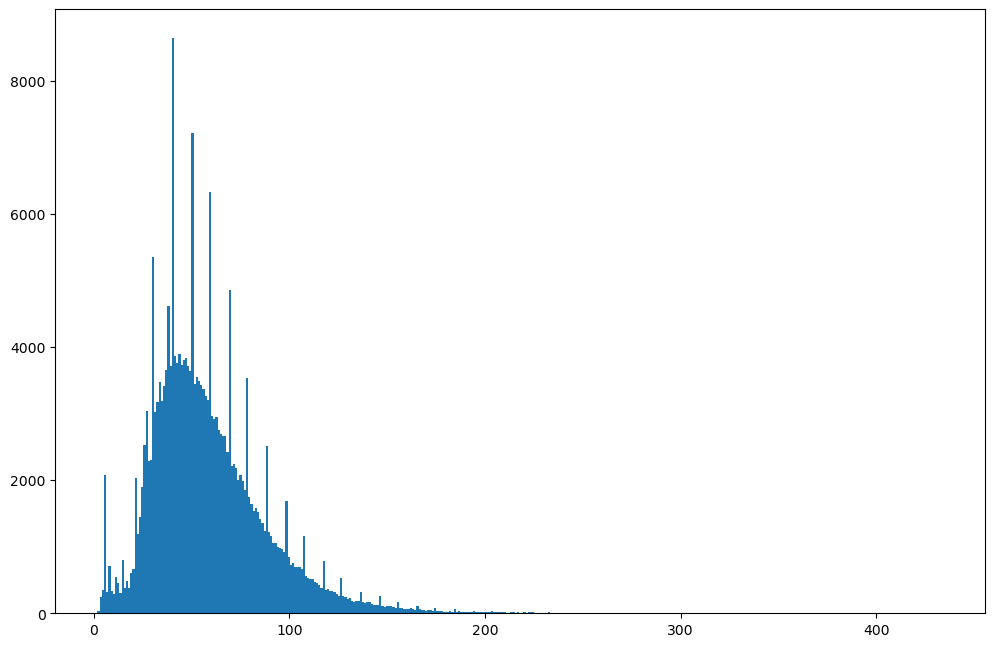

In [142]:
# np.histogram(np.array(slen), bins=100)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.hist(np.array(slen), bins='auto')
plt.show()

## Dataloader test

In [116]:
import dataset_mimic
import importlib
import misc.config

importlib.reload(dataset_mimic)
importlib.reload(misc.config)

cfg = misc.config.Config()

In [117]:
print(cfg.max_length)
data_set = dataset_mimic.build_dataset('train',cfg)
train_loader = torch.utils.data.DataLoader(
                    data_set, batch_size=8, drop_last=True,
                    shuffle=True, num_workers=0)

320


In [118]:
it = iter(train_loader)

In [120]:
for i in tqdm(range(10)):
    imgs, txts, masks, uids, cap_lens = it.next()

  0%|          | 0/10 [00:01<?, ?it/s]


ValueError: too many values to unpack (expected 5)

In [119]:
print(imgs.shape, txts.shape, masks.shape)

AttributeError: 'list' object has no attribute 'shape'

(2048, 2048)
[CLS] spinal hardware tracheostomy tube and right sided central line are unchanged in position there has been improved aeration at the left base there remains mild prominence of the pulmonary interstitial markings there are no pneumothoraces [SEP]


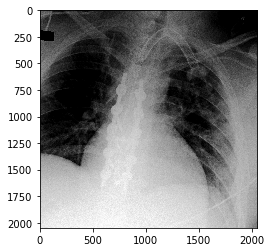

In [117]:
from matplotlib import pyplot as plt
i = 0
im = np.squeeze(imgs[i].numpy(),0)
print(im.shape)
plt.imshow(im, cmap='gray')
# masked_texts=txts
print(' '.join([idx2word[x] for x in txts.numpy()[i][:masks[i].numpy().sum()]]))
# print(masks[i].numpy())


In [122]:
np.random.choice([0,1,2,3,4])

1

In [123]:
im = Image.open('../data/ChestXRay/dataset/images/images_normalized/10_IM-0002-1001.dcm.png')

In [124]:
im.size

(2048, 2496)

In [156]:
mask.sum(-1)

tensor([45, 58, 35, 35, 39, 23, 67, 26])

In [333]:
%load_ext autoreload

In [614]:

import dataset
import importlib
importlib.reload(dataset)

<module 'dataset' from '/home/ipmi/code/dataset.py'>

In [530]:
from misc.config import Config
cfg = Config()

In [531]:
data_set = dataset.build_dataset('train',cfg=cfg)
train_loader = torch.utils.data.DataLoader(
                    data_set, batch_size=8, drop_last=True,
                    shuffle=False, num_workers=0)
it = iter(train_loader)

In [532]:
imgs,caps,masks,uids,cap_lens=it.next()

-1.0 1.0


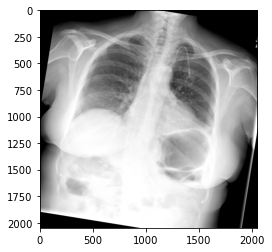

In [533]:
i = 3
im = np.squeeze(imgs[i].numpy(),0)
print(im.min(),im.max())
plt.imshow((im + 1)/(2), cmap='gray')
# print(' '.join([idx2word[x] for x in caps[i].numpy()]))
# print(masks[i].numpy())
# print(uids[i])
# print(dataset['data_dict'][uids[i].tolist()])

-0.12156862 0.45098042


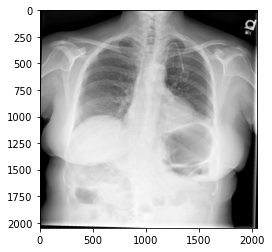

In [528]:
i = 3
im = np.squeeze(imgs[i].numpy(),0)
print(im.min(),im.max())
plt.imshow((im + 1)/(2), cmap='gray')
# print(' '.join([idx2word[x] for x in caps[i].numpy()]))
# print(masks[i].numpy())
# print(uids[i])
# print(dataset['data_dict'][uids[i].tolist()])

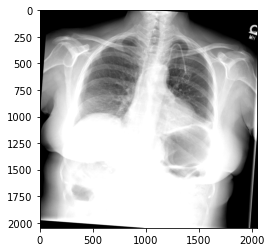

In [514]:
i = 3
im = np.squeeze(imgs[i].numpy(),0)
# print(im.shape)
plt.imshow((im + 1)/(2), cmap='gray')
# print(' '.join([idx2word[x] for x in caps[i].numpy()]))
# print(masks[i].numpy())
# print(uids[i])
# print(dataset['data_dict'][uids[i].tolist()])

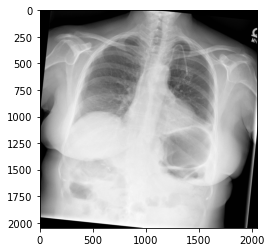

In [519]:
from matplotlib import pyplot as plt
i = 3
im = np.squeeze(imgs[i].numpy(),0)
# print(im.shape)
plt.imshow((im + 1)/(2), cmap='gray')
# print(' '.join([idx2word[x] for x in caps[i].numpy()]))
# print(masks[i].numpy())
# print(uids[i])
# print(dataset['data_dict'][uids[i].tolist()])

In [299]:
dataset['data_dict'][uids[i].tolist()]

{'filenames': ['19_IM-0583-1001.dcm.png'],
 'text': 'heart size is normal. there is tortuosity of the thoracic aorta, stable compared with prior. no focal airspace disease or effusion. no pleural effusions or pneumothoraces. degenerative changes in the thoracic spine.',
 'split': 0}

In [364]:
import torch.nn as nn
import math
# Temporarily leave PositionalEncoding module here. Will be moved somewhere else.
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        try:
            from torch.nn import TransformerEncoder, TransformerEncoderLayer
        except:
            raise ImportError('TransformerEncoder module does not exist in PyTorch 1.1 or lower.')
        self.model_type = 'Transformer'
        # self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)
        self.globalavg = nn.AdaptiveAvgPool1d(1)
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.weight)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, src, mask):

        src = self.encoder(src) * math.sqrt(self.ninp)
        print(src.shape)
        src = self.pos_encoder(src)
        word_feats = self.transformer_encoder(src, mask)  # max_len, batchsize, feats_size
        print('word_feats.shape:',word_feats.shape)
        word_feats = torch.transpose(word_feats, 1, 2)  # max_len, feats_size, batchsize
        print('word_feats.shape:',word_feats.shape)
        sent_feats = self.globalavg(word_feats[:, mask.sum(-1),:])
        print('sent_feats.shape:',sent_feats.shape)
        sent_feats = self.fc(sent_feats)
        return F.log_softmax(output, dim=-1)

In [368]:
imgs,caps,masks,uids=it.next()

In [369]:
# masks = mask
# masks.shape
caps.shape

torch.Size([8, 129])

In [382]:
def mask_(matrices, maskval=0.0, mask_diagonal=True):
    """
    Masks out all values in the given batch of matrices where i <= j holds,
    i < j if mask_diagonal is false
    In place operation
    :param tns:
    :return:
    """

    b, h, w = matrices.size()

    indices = torch.triu_indices(h, w, offset=0 if mask_diagonal else 1)
    matrices[:, indices[0], indices[1]] = maskval
################ Transformer: Text Encoder ############
class SelfAttention(nn.Module):
    def __init__(self, k, heads=8, mask=False):
        super().__init__()
        self.k, self.heads = k, heads
        # These compute the queries, keys and values for all 
        # heads (as a single concatenated vector)
        self.tokeys    = nn.Linear(k, k * heads, bias=False)
        self.toqueries = nn.Linear(k, k * heads, bias=False)
        self.tovalues  = nn.Linear(k, k * heads, bias=False)

        # This unifies the outputs of the different heads into 
        # a single k-vector
        self.unifyheads = nn.Linear(heads * k, k)
    def forward(self, x, mask):
        b, t, k = x.size()
        h = self.heads

        queries = self.toqueries(x).view(b, t, h, k)
        keys    = self.tokeys(x)   .view(b, t, h, k)
        values  = self.tovalues(x) .view(b, t, h, k)
        
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, k)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, k)
        values = values.transpose(1, 2).contiguous().view(b * h, t, k)
        
        queries = queries / (k ** (1/4))
        keys    = keys / (k ** (1/4))

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))
        # - dot has size (b*h, t, t) containing raw weights

        
        if self.mask: # mask out the upper half of the dot matrix, excluding the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False)
        
        dot = F.softmax(dot, dim=2) 
        # - dot now contains row-wise normalized weights
        
        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, k)
        
        out = out.transpose(1, 2).contiguous().view(b, t, h * k)
        return self.unifyheads(out)

class TransformerBlock(nn.Module):
    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.0, wide=True):
        super().__init__()
        self.attention = SelfAttention(k=emb, heads=heads)        
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb)
        )
        self.do = nn.Dropout(dropout)

    def forward(self, x):

        attended = self.attention(x)

        x = self.norm1(attended + x)

        x = self.do(x)

        fedforward = self.ff(x)

        x = self.norm2(fedforward + x)

        x = self.do(x)

        return x
    
    
class TEXT_TRANSFORMER_ENCODER(nn.Module):
    def __init__(self, emb, heads, depth, seq_length, num_tokens, dropout=0.2, wide=False):
        super().__init__()

        self.num_tokens = num_tokens
        self.wemb_linear  = nn.Linear(768, emb, bias=False)
        self.token_embedding = nn.Embedding(embedding_dim=768, num_embeddings=num_tokens)
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb
                                 , heads=heads
                                 , seq_length=seq_length
                                 , mask=True
                                 , dropout=dropout
                                 , wide=wide))

        self.tblocks = nn.Sequential(*tblocks)

        self.do = nn.Dropout(dropout)

    def init_embeddings(self, word_embedding, positional_embedding, IsTrainable):
        self.token_embedding.weight.data = word_embedding
        self.token_embedding.weight.requires_grad = IsTrainable
        
        self.pos_embedding.weight.data = positional_embedding
        self.pos_embedding.weight.requires_grad = False
        
        
    def forward(self, x,masks):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        tokens = self.token_embedding(x)
        tokens = self.wemb_linear(tokens)
        
        b, t, e = tokens.size()
#         print('b:{0}, t:{1}, e:{2}'.format(b, t, e))
        positions = torch.arange(t)        
        positions = self.pos_embedding(positions)[None, :, :].expand(b, t, e)
        
#         print('positions:',positions.size())
        x = tokens + positions
        x = self.do(x)

#         print('x:',x.size())
        words_emb = self.tblocks(x)
        sent_emb = words_emb.mean(dim=1) # pool over the time dimension
        words_emb = torch.transpose(words_emb,1,2)
        
#         print('words_emb:',words_emb.shape,'sent_emb:',sent_emb.shape)

        return words_emb,sent_emb

In [383]:
transformer_model = TEXT_TRANSFORMER_ENCODER(emb=512,heads=8,depth=4,seq_length=150,num_tokens=data_set.vocab_size)

In [384]:
transformer_model(caps,masks)

TypeError: forward() missing 1 required positional argument: 'mask'

In [386]:
from transformers import BertConfig, BertModel

In [388]:
config = BertConfig(vocab_size=1196, hidden_size=512, num_hidden_layers=3,
                    num_attention_heads=8, intermediate_size=2048, hidden_act='gelu',
                    hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1,
                    max_position_embeddings=512, layer_norm_eps=1e-12,
                    initializer_range=0.02, type_vocab_size=2, pad_token_id=0)

In [391]:
model = BertModel(config,add_pooling_layer=False )

In [392]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(1196, 512, padding_idx=0)
    (position_embeddings): Embedding(512, 512)
    (token_type_embeddings): Embedding(2, 512)
    (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=512, out_features=512, bias=True)
            (key): Linear(in_features=512, out_features=512, bias=True)
            (value): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=512, out_features=512, bias=True)
            (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )

In [393]:
output = model(input_ids=caps, attention_mask=masks)

In [425]:
m = nn.AdaptiveAvgPool1d(1)
_input = torch.randn(1, 64, 8)
output = m(_input)
output.shape

torch.Size([1, 64, 1])

In [455]:
from transformers import BertPreTrainedModel

class TextEncoder(nn.Module):
    def __init__(self, config):
        super(TextEncoder, self).__init__()
        
        bert = BertModel(config, add_pooling_layer=False)

        self.bert = bert
        self.sent = nn.Linear(512, 512)
        
    def forward(self, x, mask):
        word_feat = self.bert(input_ids=x, attention_mask=mask)[0]
        print(word_feat.shape)
        sent_feat = word_feat[:,0,:]
        sent_feat = self.sent(sent_feat)       
        return sent_feat, word_feat

In [ ]:
word_feat = [129] ['CLS'] ['SEP'] ['PAD'] -> w_loss
word_feat[:,1:,:] -> [8,128,512] 

In [465]:
model = TextEncoder(config)

In [457]:
sent_feats, word_feats = model(caps,masks)

torch.Size([8, 129, 512])


In [466]:
std = model.state_dict()

In [467]:
std.keys()

odict_keys(['bert.embeddings.position_ids', 'bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.LayerNorm.weigh

In [469]:
std['bert.embeddings.word_embeddings.weight'][0,:] = 0.5
std['bert.embeddings.word_embeddings.weight']

tensor([[ 5.0000e-01,  5.0000e-01,  5.0000e-01,  ...,  5.0000e-01,
          5.0000e-01,  5.0000e-01],
        [-4.2670e-03, -2.2661e-02,  1.3596e-04,  ...,  5.9003e-03,
          4.3368e-02,  9.3442e-03],
        [ 2.3720e-02, -3.3314e-02, -5.4340e-03,  ...,  2.6354e-02,
          2.7614e-02, -7.6545e-03],
        ...,
        [-1.0447e-02, -4.0221e-02,  1.9034e-02,  ...,  5.2405e-03,
          1.2785e-02, -1.9273e-03],
        [ 4.7300e-02, -1.9325e-02, -1.7531e-02,  ...,  1.9294e-02,
         -1.9019e-03, -2.4678e-02],
        [-2.0812e-02, -2.3854e-02,  2.0967e-02,  ..., -5.1604e-03,
          3.7881e-02, -9.3478e-03]])

In [470]:
torch.save(std, 'save/temp.pth')

In [471]:
model2 = TextEncoder(config)

In [472]:
model2.state_dict()['bert.embeddings.word_embeddings.weight'][0]

tensor([ 7.8821e-03, -3.5045e-02,  1.4121e-02,  9.7070e-03, -3.3117e-03,
         9.6901e-03, -9.9555e-03, -1.8174e-02, -3.8385e-03, -1.5379e-02,
        -7.4687e-03,  1.5972e-03,  1.9328e-03,  1.9457e-02, -2.0138e-02,
         4.2976e-03, -9.5875e-03, -3.6648e-02, -1.6565e-02, -3.1241e-02,
        -5.4579e-03, -2.5698e-02,  6.6400e-03,  5.8831e-03,  1.5531e-02,
        -4.2414e-02,  1.3612e-02, -2.0310e-02, -8.0668e-03, -1.7462e-02,
         8.1628e-03, -1.9570e-02, -2.6664e-02,  6.3397e-03, -1.2849e-02,
        -3.0738e-02, -1.0288e-02,  1.9230e-02, -2.8008e-02,  2.0703e-02,
        -2.4501e-02,  3.3865e-02,  1.8946e-02, -2.1086e-03, -7.6355e-03,
        -1.2183e-02, -2.0348e-02, -2.1568e-02, -8.3113e-04,  2.7576e-02,
        -9.1024e-03, -7.6377e-03,  1.9110e-02,  4.4322e-03,  2.2333e-02,
        -3.4987e-02, -2.8900e-02,  1.5573e-02, -1.0295e-02, -8.2119e-03,
         2.0436e-02,  1.8305e-02,  1.1611e-02,  5.6134e-02,  8.8095e-03,
        -3.2502e-02,  6.2666e-03,  8.0496e-03, -1.4

In [473]:
tds = torch.load('save/temp.pth', map_location='cpu')
model2.load_state_dict(tds)

<All keys matched successfully>

In [474]:
model2.state_dict()['bert.embeddings.word_embeddings.weight'][0]

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 

In [551]:
import model
importlib.reload(model)

<module 'model' from '/home/ipmi/code/model.py'>

In [552]:
md = model.ImageEncoder()

In [553]:
wf, sf = md(imgs)

torch.Size([8, 2048])


In [554]:
print(wf.shape, sf.shape)

torch.Size([8, 512, 16, 16]) torch.Size([8, 512])


In [626]:
im = Image.open('../data/ChestXRay/dataset/images/images_normalized/907_IM-2412-82526002.dcm.png')

In [630]:
im = im.resize((2048,2048))

In [632]:
im.save('../data/ChestXRay/dataset/images/images_normalized/907_IM-2412-82526002.dcm.png')

In [592]:
2048/im.size[0]

1.003921568627451

In [593]:
im.size[1]*1.003921568627451

2248.7843137254904

In [635]:
importlib.reload(dataset)

<module 'dataset' from '/home/ipmi/code/dataset.py'>

In [639]:

data_set = dataset.build_dataset('train',cfg=cfg)
train_loader = torch.utils.data.DataLoader(
                    data_set, batch_size=32, drop_last=False,
                    shuffle=False, num_workers=8)
it = iter(train_loader)

In [640]:
for i in range(len(train_loader)):
    it.next()
    print(i,end='\r')

In [643]:
train_loader.dataset.vocab_size

1196

In [ ]:
'/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/'